## Part B Question 2

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
import graphviz
import pydot_ng as pydot
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup
from math import floor
from math import sqrt 

In [3]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [4]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [5]:
from keras import backend as K
def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## From Question 1

In [6]:
# Split data

train_dataframe = df[df['year']<= 2020] 
test_dataframe =  df[df['year']>2020]

In [7]:
category_not_used = ["full_address", "nearest_stn"]
train_dataframe = train_dataframe.drop(category_not_used, axis = 1)
test_dataframe = test_dataframe.drop(category_not_used, axis = 1)

train_ds = dataframe_to_dataset(train_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

train_ds = train_ds.batch(256)
test_ds = test_ds.batch(256)

In [8]:
#Categorical feature encoded as integer
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")

In [9]:
all_inputs = [month,flat_model_type,storey_range,dist_to_nearest_stn,
            dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years,floor_area_sqm]

## Question 2

## Question 2A

#### Further split of training dataset to train and validation

In [10]:
Q2_validation_dataframe = train_dataframe[train_dataframe["year"]==2020]
Q2_train_dataframe = train_dataframe[train_dataframe["year"]<2020]

In [11]:
Q2_train_ds = dataframe_to_dataset(Q2_train_dataframe)
Q2_val_ds = dataframe_to_dataset(Q2_validation_dataframe)

Q2_train_ds = Q2_train_ds.batch(256)
Q2_val_ds = Q2_val_ds.batch(256)

## Question 2B

In [12]:
def Q2_encode_categorical_feature(feature, name, dataset, is_string, num_categories, divisor):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x,-1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)

    emb = layers.Embedding(input_dim=num_categories+1, output_dim=floor(num_categories//divisor))
    embedded = emb(encoded_feature)

    return layers.Flatten()(embedded)


## Question 2C

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [14]:
# Numerical features encoded wit Q2_train_ds
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", Q2_train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", Q2_train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", Q2_train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", Q2_train_ds)
remaining_lease_year_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", Q2_train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm", Q2_train_ds)

In [15]:
import keras_tuner
def build_model(hp):    
    Q2_optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 2e-1, sampling='log'))
    divisor = hp.Int("divisor", min_value=1, max_value=2, step=1)

    hidden_units = hp.Int("hidden_units", min_value=4, max_value=32, step=4)
    

    month_num_categories = df["month"].nunique()
    flat_model_type_num_categories = df["flat_model_type"].nunique()
    storey_range_num_categories = df["storey_range"].nunique()


    #Integer categorical features
    month_embedded = Q2_encode_categorical_feature(month, "month",Q2_train_ds, False, month_num_categories, divisor)
    #String categorical features
    flat_model_type_embedded = Q2_encode_categorical_feature(flat_model_type, "flat_model_type",Q2_train_ds, True, flat_model_type_num_categories, divisor)
    storey_range_embedded = Q2_encode_categorical_feature(storey_range, "storey_range",Q2_train_ds, True, storey_range_num_categories, divisor)
    
    Q2_all_features = layers.Concatenate()(
                    [
                        month_embedded,
                        storey_range_embedded,
                        flat_model_type_embedded,
                        floor_area_sqm_encoded,
                        remaining_lease_year_encoded,
                        degree_centrality_encoded,
                        eigenvector_centrality_encoded,
                        dist_to_nearest_stn_encoded,
                        dist_to_dhoby_encoded
                    ]
        )
    hidden_layer = layers.Dense(units=hidden_units, activation ="linear")(Q2_all_features)
    Q2_output = layers.Dense(1, activation="linear")(hidden_layer)
    Q2_model = keras.Model(all_inputs, Q2_output)
    Q2_model.compile(optimizer=Q2_optimizer, loss= "mse",metrics=[r2])

    return Q2_model

In [16]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10)

tuner.search(Q2_train_ds, epochs=50, validation_data=Q2_val_ds, callbacks=[callback])
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

Trial 10 Complete [00h 01m 21s]
val_loss: 206107623424.0

Best val_loss So Far: 3843214080.0
Total elapsed time: 00h 12m 29s
INFO:tensorflow:Oracle triggered exit


#### Best hyperparamters 

In [17]:
best_hyperparameters.values

{'learning_rate': 0.046185127256095915, 'divisor': 2, 'hidden_units': 8}

## Question 2D 
**Training of model based on best model configuration and test RMSE** 

In [18]:
Q2_best_model_history = {}
Q2_best_model = build_model(best_hyperparameters)

# Save best epoch only
callback_list = [
       tf.keras.callbacks.ModelCheckpoint(
            filepath='PartB_bestepoch/', 
            save_freq='epoch', verbose=1, monitor='val_loss', 
            save_weights_only=True, save_best_only=True
       )         
]

# Train on the non-test split ( 2020 and before hence using train_ds instead of Q2_train_ds)
Q2_best_model_history["best_model"] = Q2_best_model.fit(train_ds, epochs=50, validation_data = test_ds, verbose=1, callbacks=callback_list)

# Save the model train with the optimal hyperparameters
Q2_best_model.save('PartB_best_model/')

Epoch 1/50
329/342 [===========================>..] - ETA: 0s - loss: 82699100160.0000 - r2: -2.5223
Epoch 1: val_loss improved from inf to 17899706368.00000, saving model to PartB_bestepoch\
342/342 [==============================] - 3s 6ms/step - loss: 80105832448.0000 - r2: -2.4058 - val_loss: 17899706368.0000 - val_r2: 0.3491
Epoch 2/50
342/342 [==============================] - ETA: 0s - loss: 9185911808.0000 - r2: 0.6118
Epoch 2: val_loss improved from 17899706368.00000 to 14939295744.00000, saving model to PartB_bestepoch\
342/342 [==============================] - 2s 5ms/step - loss: 9185911808.0000 - r2: 0.6118 - val_loss: 14939295744.0000 - val_r2: 0.4546
Epoch 3/50
337/342 [============================>.] - ETA: 0s - loss: 7962473984.0000 - r2: 0.6631
Epoch 3: val_loss improved from 14939295744.00000 to 14265612288.00000, saving model to PartB_bestepoch\
342/342 [==============================] - 3s 7ms/step - loss: 7957949952.0000 - r2: 0.6635 - val_loss: 14265612288.0000 -

In [19]:
def square_roots(l):
    result = [sqrt(i) for i in l]
    return result

#### Plot of Train & Test RMSE for 50 epochs

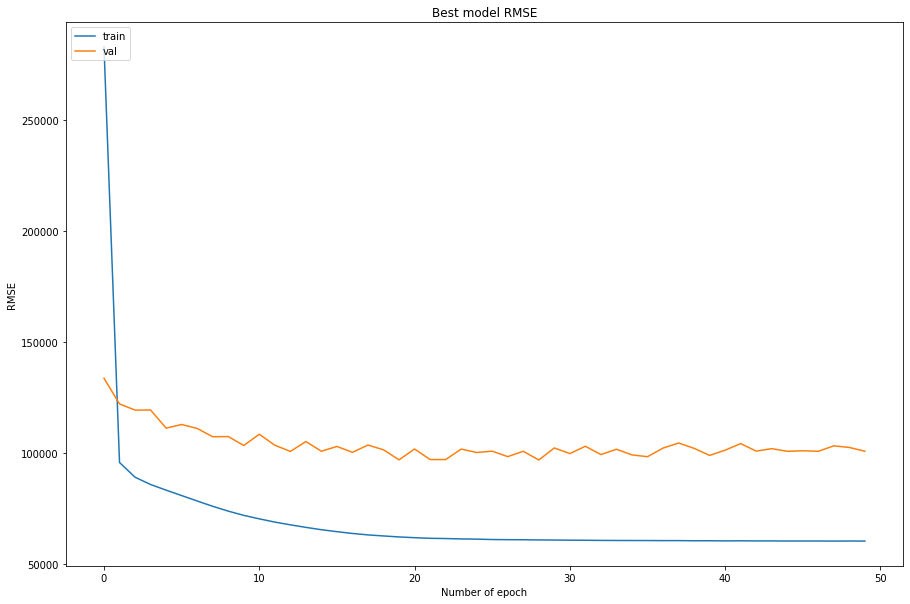

In [20]:
import matplotlib.pyplot as plt
plt_1 = plt.figure(figsize=(15, 10))
# Plot 
plt.plot(square_roots(Q2_best_model_history['best_model'].history['loss']))
plt.plot(square_roots(Q2_best_model_history['best_model'].history['val_loss']))
plt.title('Best model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Number of epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Plot of Train & Test R^2 for 50 epochs

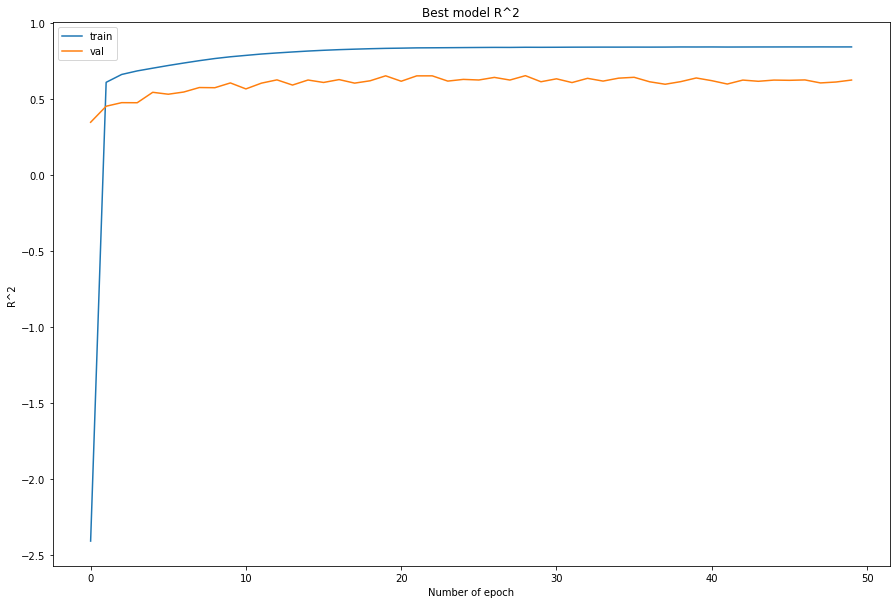

In [21]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(Q2_best_model_history['best_model'].history['r2'])
plt.plot(Q2_best_model_history['best_model'].history['val_r2'])
plt.title('Best model R^2')
plt.ylabel('R^2')
plt.xlabel('Number of epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Question 2E

In [22]:
# Do a prediction on test set and look for error against predicted - actual


def flatten(l):
    return [item for sublist in l for item in sublist]

def df_to_dataset(dataframe):
    dataframe = dataframe.copy()
    
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    return ds

## We use the test dataframe defined in the first question (Test > 2020)
Q2E_test_df = test_dataframe.copy()
Q2E_test_ds = df_to_dataset(Q2E_test_df)
Q2E_test_ds = Q2E_test_ds.batch(256)

# Load the best weights 
Q2_best_model.load_weights('PartB_bestepoch/')

prediction =  Q2_best_model.predict(Q2E_test_ds)
prediction = flatten(prediction)
data_df = test_dataframe.copy()
data_df["Predicted Resale Value"] = prediction

data_df["Error"] = abs(data_df["resale_price"] - data_df["Predicted Resale Value"])
data_df = data_df.sort_values(by="Error", ascending=False)
data_df = data_df.head(30)

data_df

 15/180 [=>............................] - ETA: 0s 

c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 1s 4ms/step


,month,year,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price,Predicted Resale Value,Error
119399,5,2022,0.586629,2.932814,0.016807,0.047782,"5 ROOM, Improved",96.083333,113.0,40 TO 42,1400000.0,909732.6250,490267.3750
114504,12,2021,0.428356,8.948410,0.016807,0.001358,"EXECUTIVE, Maisonette",66.666667,154.0,04 TO 06,1238000.0,748863.2500,489136.7500
127227,8,2022,0.489478,3.977493,0.016807,0.008342,"5 ROOM, Premium Apartment",93.083333,104.0,13 TO 15,1181000.0,704023.7500,476976.2500
119400,5,2022,0.586629,2.932814,0.016807,0.047782,"5 ROOM, Improved",96.083333,113.0,46 TO 48,1380000.0,911085.6875,468914.3125
120164,1,2022,0.271583,9.003026,0.016807,0.001358,"EXECUTIVE, Maisonette",65.666667,146.0,07 TO 09,1202000.0,734976.1875,467023.8125
121586,4,2022,0.245502,9.313260,0.016807,0.001179,"5 ROOM, Improved",95.333333,112.0,22 TO 24,1188000.0,733256.8750,454743.1250
127207,8,2022,0.504800,5.727076,0.016807,0.010276,"5 ROOM, Model A",73.166667,138.0,07 TO 09,1128000.0,678749.3750,449250.6250
120166,3,2022,0.271583,9.003026,0.016807,0.001358,"EXECUTIVE, Maisonette",65.500000,146.0,13 TO 15,1198000.0,750380.7500,447619.2500
117107,7,2022,1.216557,8.071776,0.016807,0.006243,"EXECUTIVE, Apartment",72.833333,146.0,04 TO 06,1120000.0,677427.7500,442572.2500
127251,8,2022,0.334556,5.561626,0.016807,0.010276,"5 ROOM, Improved",75.333333,124.0,25 TO 27,1200000.0,757516.2500,442483.7500


#### Identifying the patterns and trends with a histogram plots of certain features

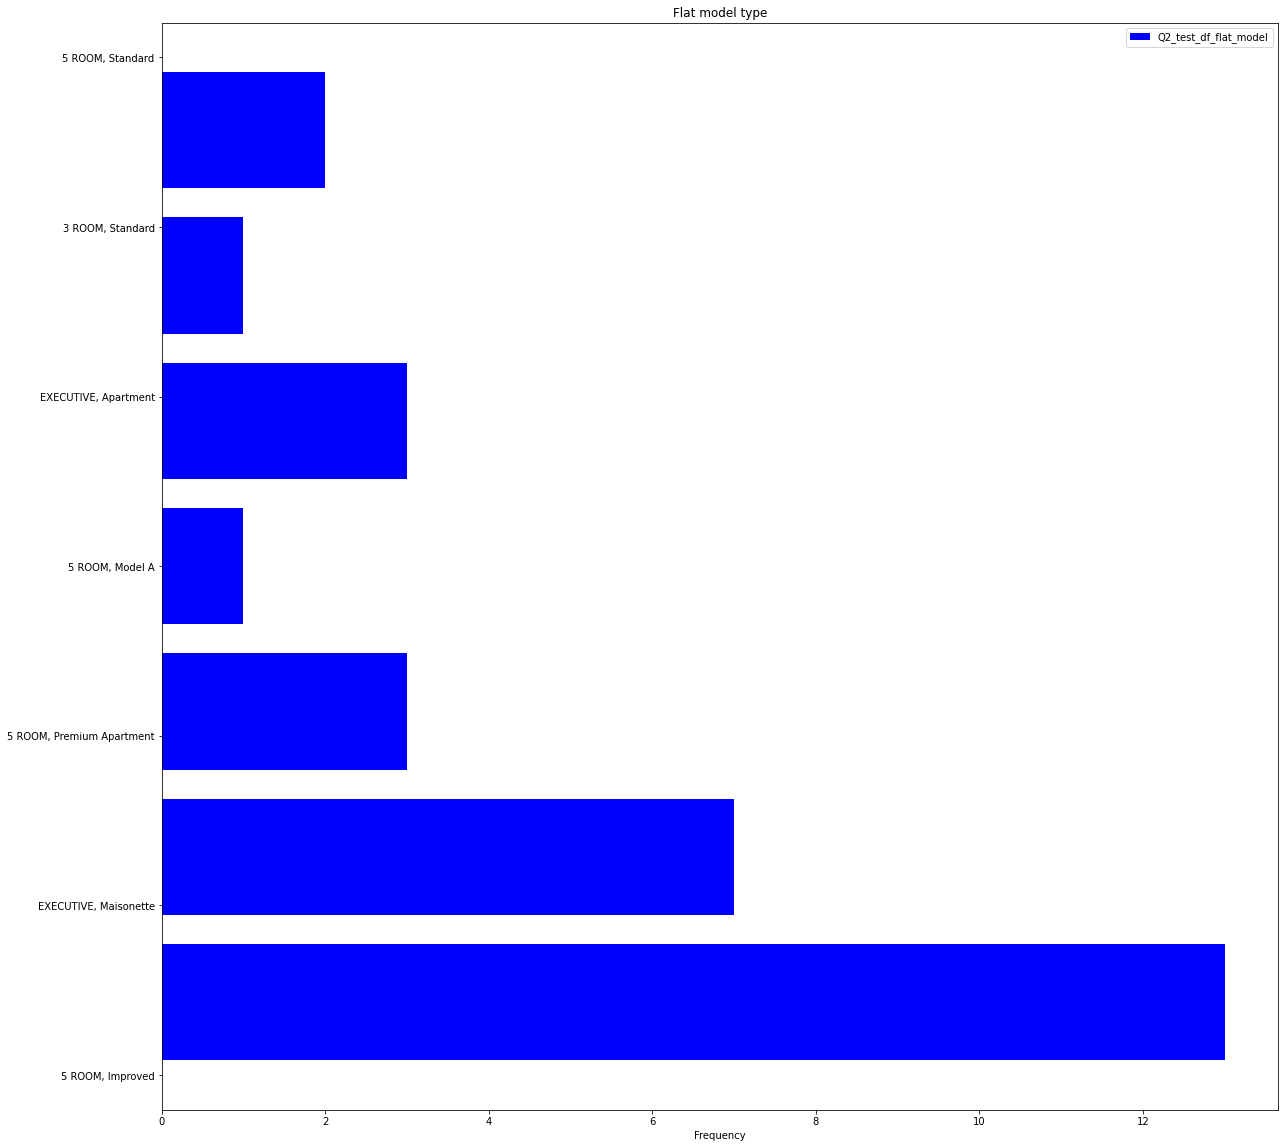

In [23]:
fig, axes =plt.subplots(1, figsize=(20,20))
axes.hist(data_df['flat_model_type'],bins = data_df["flat_model_type"].nunique(), histtype='bar', color =['blue'], label=[ 'Q2_test_df_flat_model'],rwidth=0.8, orientation='horizontal')
axes.legend(loc='upper right')
axes.set_title('Flat model type')
axes.set_xlabel('Frequency')
plt.show()

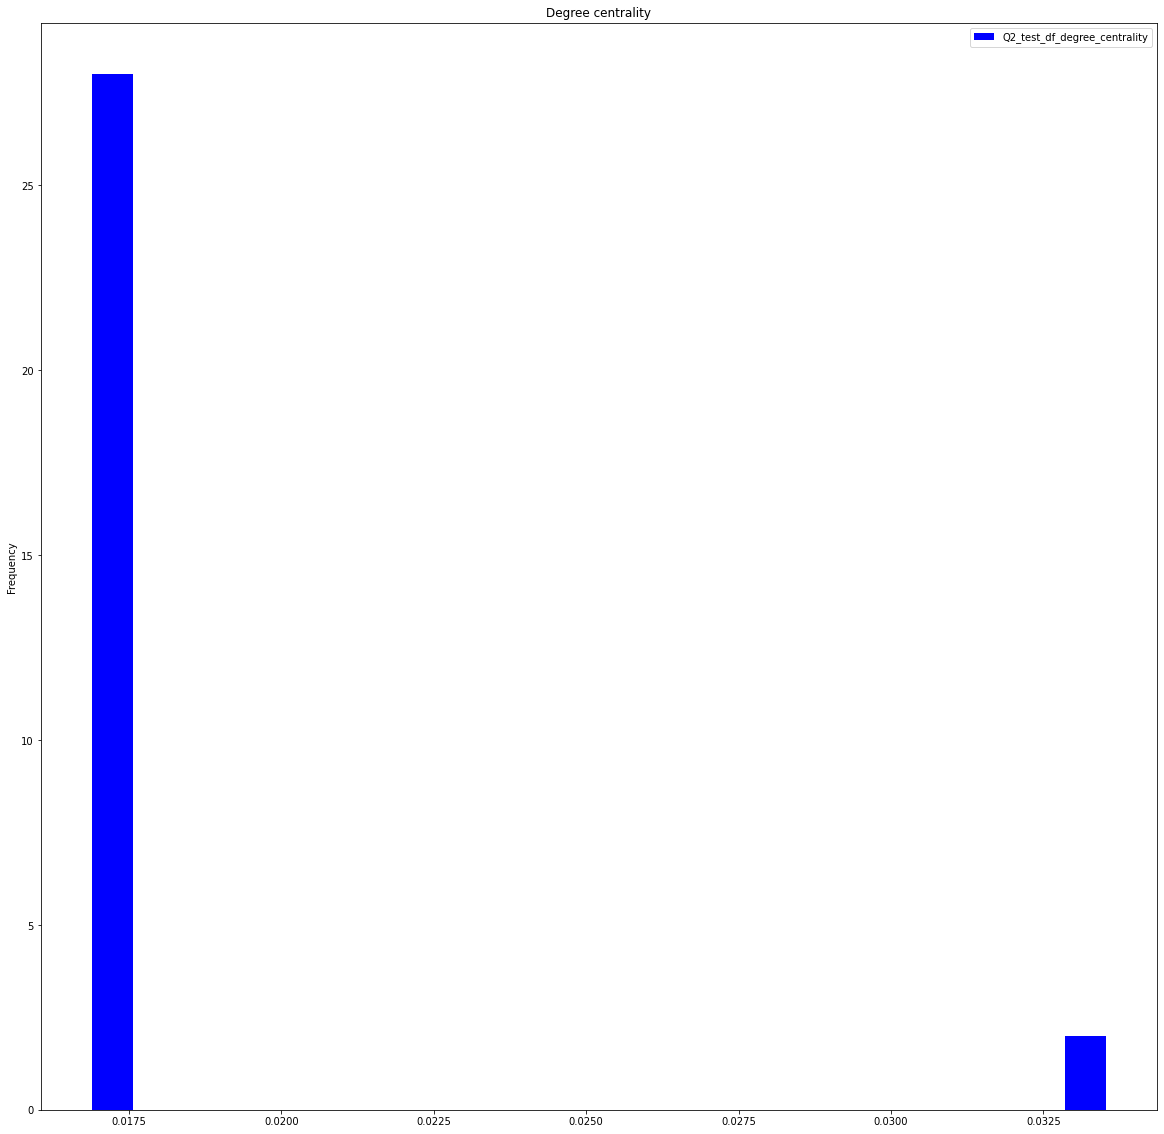

In [24]:
fig, axes =plt.subplots(1, figsize=(20,20))
axes.hist(data_df['degree_centrality'],bins = 20, histtype='bar', color =['blue'], label=[ 'Q2_test_df_degree_centrality'],rwidth=0.8)
axes.legend(loc='upper right')
axes.set_title('Degree centrality')
axes.set_ylabel('Frequency')
plt.show()

#### List down the trends

**Since the best model was train using train_ds, I will be using test_ds for the model's prediction. From the model's prediction, we can see that the largest error mainly comes from high value HDB apartment (5 room or better). This could be due to sharp rise in prices of 5 room or better HDB apartments over the past few years as compared to the other flat types**. 

**In addition, the degree centrality mainly holds at the value = 0.016807**

**An alternative solution will be to introduce more data into the training dataset which are from the past year(2021) and current year(2022) such that the model have the information to learn about current HDB pricing trends**